In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torchinfo import summary 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import os, glob, random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Diagnosis
COPD         32
ILD          24
Asthma        8
Healthy       8
Infection     6
Name: count, dtype: int64


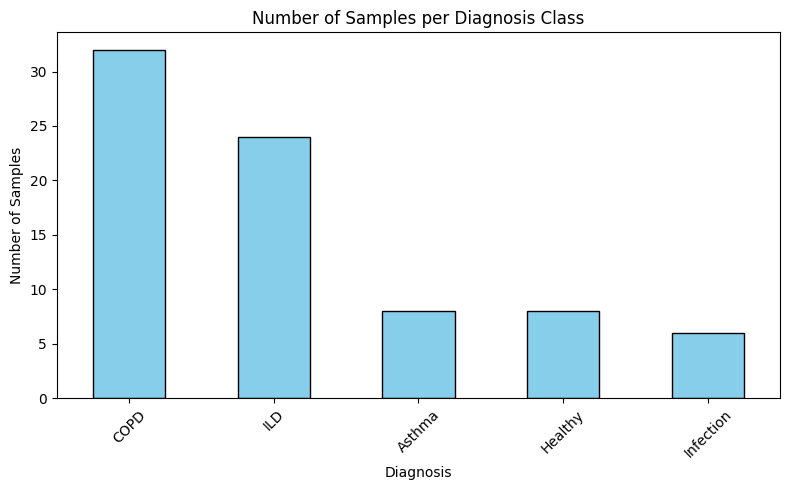

In [2]:
metadata=pd.read_csv("/kaggle/input/meta-data/Metadata.csv")


class_counts = metadata['Diagnosis'].value_counts()
print(class_counts)


plt.figure(figsize=(8,5))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Samples per Diagnosis Class')
plt.xlabel('Diagnosis')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
base_dir = "//kaggle/input/data-aug-20-secs/augmented_data"
metadata_csv = "/kaggle/input/meta-data/Metadata.csv"


meta = pd.read_csv(metadata_csv)


meta["SubjectID"] = meta["SubjectID"].astype(str).str.zfill(2)


diagnosis_map = dict(zip(meta["SubjectID"], meta["Diagnosis"]))

counts = defaultdict(int)


for patient_id in os.listdir(base_dir):
    patient_path = os.path.join(base_dir, patient_id)
    if not os.path.isdir(patient_path):
        continue

    
    label = diagnosis_map.get(patient_id)
    if not label:
        continue

    
    for subfolder in ["BELL", "DIAP", "EXTD"]:
        folder_path = os.path.join(patient_path, subfolder)
        if os.path.exists(folder_path):
            npy_files = [f for f in os.listdir(folder_path) if f.endswith(".npy")]
            counts[label] += len(npy_files)


counts_df = pd.DataFrame(list(counts.items()), columns=["Diagnosis", "Spectrogram Count"])
print(counts_df)

   Diagnosis  Spectrogram Count
0        ILD               1152
1     Asthma               1152
2       COPD               1152
3  Infection               1152
4    Healthy               1152


Spectrogram dimensions: (40, 626)


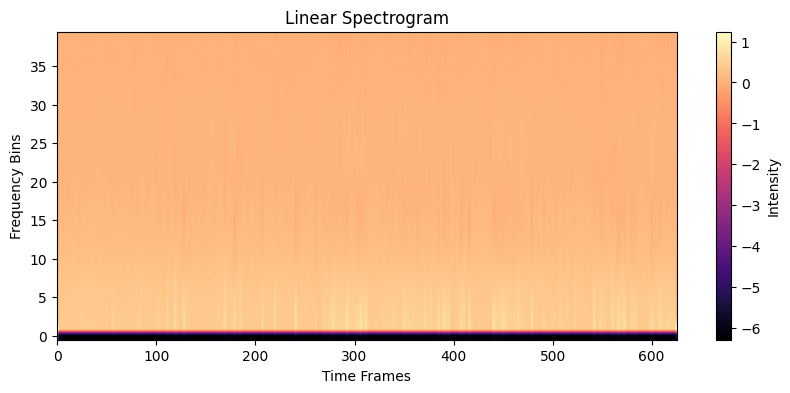

In [4]:
spec = np.load('/kaggle/input/data-aug-20-secs/augmented_data/05/BELL/05_03_PBR.npy')


print(f"Spectrogram dimensions: {spec.shape}")
plt.figure(figsize=(10,4))
plt.imshow(spec, aspect='auto', origin='lower', cmap='magma')
plt.colorbar(label="Intensity")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")
plt.title("Linear Spectrogram")
plt.show()

In [5]:
metadata = pd.read_csv("/kaggle/input/meta-data/Metadata.csv")


metadata["SubjectID"] = metadata["SubjectID"].astype(str).str.zfill(2)

base_dir = "/kaggle/input/data-aug-20-secs/augmented_data"
records = []


for subject_id in os.listdir(base_dir):
    subject_path = os.path.join(base_dir, subject_id)
    if not os.path.isdir(subject_path):
        continue
    
    total_spects = 0
    for subfolder in ["BELL", "DIAP", "EXTD"]:
        folder_path = os.path.join(subject_path, subfolder)
        if os.path.exists(folder_path):
            total_spects += len([f for f in os.listdir(folder_path) if f.endswith(".npy")])
    
    records.append({"SubjectID": subject_id, "Spectrograms": total_spects})

spect_counts = pd.DataFrame(records)


final_df = pd.merge(metadata, spect_counts, on="SubjectID")


diagnosis_counts = final_df.groupby("Diagnosis")["Spectrograms"].sum().reset_index()

print("Per subject (with metadata):\n", final_df.head())
print("\nPer diagnosis total:\n", diagnosis_counts)

Per subject (with metadata):
   SubjectID  Age Gender  Height  Weight   BMI Diagnosis   Place  Spectrograms
0        01   75      F    1.55    67.6  28.1      COPD  Aveiro            21
1        02   60      F    1.54    68.1  28.7       ILD  Aveiro            36
2        03   72      M    1.72    58.6  19.8      COPD  Aveiro            30
3        04   59      M    1.71    91.4  31.3      COPD  Aveiro            30
4        05   65      F    1.56    63.9  26.3      COPD  Aveiro            30

Per diagnosis total:
    Diagnosis  Spectrograms
0     Asthma          1152
1       COPD          1152
2    Healthy          1152
3        ILD          1152
4  Infection          1152


In [6]:
BASE_DIR = "/kaggle/input/data-aug-20-secs/augmented_data" 
META_CSV = "//kaggle/input/meta-data/Metadata.csv"

meta = pd.read_csv(META_CSV, dtype={"SubjectID": str})
meta["SubjectID"] = meta["SubjectID"].astype(str).str.zfill(2)

In [7]:
rows = []
for subject in os.listdir(BASE_DIR):
    subj_path = os.path.join(BASE_DIR, subject)
    if not os.path.isdir(subj_path):
        continue
    for sub in ["BELL", "DIAP", "EXTD"]:
        folder = os.path.join(subj_path, sub)
        if not os.path.exists(folder): continue
        for filepath in glob.glob(os.path.join(folder, "*.npy")):
            rows.append({"SubjectID": subject, "filepath": filepath})

files_df = pd.DataFrame(rows)
df = files_df.merge(meta, on="SubjectID", how="left")
df = df.dropna(subset=["Diagnosis"]).reset_index(drop=True)
print("Total spectrograms:", len(df))
df.head()

Total spectrograms: 5760


,SubjectID,filepath,Age,Gender,Height,Weight,BMI,Diagnosis,Place
0,47,/kaggle/input/data-aug-20-secs/augmented_data/...,61,M,1.72,71.0,24.0,ILD,Aveiro
1,47,/kaggle/input/data-aug-20-secs/augmented_data/...,61,M,1.72,71.0,24.0,ILD,Aveiro
2,47,/kaggle/input/data-aug-20-secs/augmented_data/...,61,M,1.72,71.0,24.0,ILD,Aveiro
3,47,/kaggle/input/data-aug-20-secs/augmented_data/...,61,M,1.72,71.0,24.0,ILD,Aveiro
4,47,/kaggle/input/data-aug-20-secs/augmented_data/...,61,M,1.72,71.0,24.0,ILD,Aveiro


In [8]:
class SpectrogramDataset(Dataset):
    def __init__(self, df, label_encoder=None, max_len=512, scaler=None, training=True):
        self.df = df.reset_index(drop=True)
        if label_encoder is None:
            self.le = LabelEncoder()
            self.df["label"] = self.le.fit_transform(self.df["Diagnosis"])
        else:
            self.le = label_encoder
            self.df["label"] = self.le.transform(self.df["Diagnosis"])

        self.max_len = max_len
        self.training = training

        
        def encode_gender(g):
            if pd.isna(g): return 2
            g = str(g).lower()
            if g in ["m", "male"]: return 0
            if g in ["f", "female"]: return 1
            return 2
        self.df["gender_code"] = self.df["Gender"].apply(encode_gender)

        meta_vals = self.df[["Age", "BMI", "gender_code"]].astype(float).fillna(0).values
        if scaler is None:
            self.scaler = StandardScaler()
            self.scaler.fit(meta_vals)
        else:
            self.scaler = scaler
        self.meta_scaled = self.scaler.transform(meta_vals).astype(np.float32)

    def __len__(self): return len(self.df)

    def _load_spec(self, path):
        arr = np.load(path)
        if arr.ndim == 1:
            arr = arr[np.newaxis, :]
        elif arr.ndim == 2:
            pass  
        else:
            arr = arr.squeeze()
            if arr.ndim == 1: arr = arr[np.newaxis, :]
        return arr.astype(np.float32)

    def _pad_or_crop(self, arr):
        c, L = arr.shape
        if L == self.max_len: return arr
        if L < self.max_len:
            pad = np.zeros((c, self.max_len), dtype=arr.dtype)
            start = (self.max_len - L)//2
            pad[:, start:start+L] = arr
            return pad
        start = random.randint(0, L-self.max_len) if self.training else (L-self.max_len)//2
        return arr[:, start:start+self.max_len]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        spec = self._load_spec(row["filepath"])
        spec = self._pad_or_crop(spec)

        
        mean, std = spec.mean(), spec.std() if spec.std()>1e-6 else 1.0
        spec = (spec - mean) / std
        spec_t = torch.from_numpy(spec).float() 
        

        meta = torch.from_numpy(self.meta_scaled[idx])
        label = int(row["label"])
        return {"spec": spec_t, "meta": meta, "label": label}

In [9]:
class CNN1DGRU(nn.Module):
    def __init__(self, in_channels, meta_dim=3, n_classes=5, hidden=128, layers=1, bidirectional=True):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(2)

        self.gru = nn.GRU(input_size=256, hidden_size=hidden, num_layers=layers,
                          bidirectional=bidirectional, batch_first=False)
        out_dim = hidden * (2 if bidirectional else 1)
        self.fc = nn.Sequential(
            nn.Linear(out_dim + meta_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )

    def forward(self, x, meta):
        x = F.relu(self.bn1(self.conv1(x))); x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x))); x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3(x))); x = self.pool3(x)

        
        
        x = x.permute(2,0,1)
        out, _ = self.gru(x)
        last = out[-1]  
        
        cat = torch.cat([last, meta], dim=1)
        return self.fc(cat)

In [10]:
def train_one_epoch(model, loader, opt, criterion, device):
    model.train(); total_loss=0; correct=0; total=0
    for batch in tqdm(loader, desc="Train", leave=False):
        spec, meta, labels = batch["spec"].to(device), batch["meta"].to(device), batch["label"].to(device)
        opt.zero_grad()
        out = model(spec, meta)
        loss = criterion(out, labels)
        loss.backward(); opt.step()
        total_loss += loss.item()*spec.size(0)
        correct += (out.argmax(1)==labels).sum().item()
        total += spec.size(0)
    return total_loss/total, correct/total

def evaluate(model, loader, criterion, device):
    model.eval(); total_loss=0; correct=0; total=0
    with torch.no_grad():
        for batch in tqdm(loader, desc="Eval", leave=False):
            spec, meta, labels = batch["spec"].to(device), batch["meta"].to(device), batch["label"].to(device)
            out = model(spec, meta)
            loss = criterion(out, labels)
            total_loss += loss.item()*spec.size(0)
            correct += (out.argmax(1)==labels).sum().item()
            total += spec.size(0)
    return total_loss/total, correct/total

In [11]:
df["label"] = LabelEncoder().fit_transform(df["Diagnosis"])
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

train_ds = SpectrogramDataset(train_df, max_len=512, training=True)
val_ds   = SpectrogramDataset(val_df,   label_encoder=train_ds.le, scaler=train_ds.scaler, training=False)
test_ds  = SpectrogramDataset(test_df,  label_encoder=train_ds.le, scaler=train_ds.scaler, training=False)

in_channels = np.load(train_df.iloc[0]["filepath"]).squeeze().shape[0] if np.load(train_df.iloc[0]["filepath"]).ndim==2 else 1
n_classes = len(train_ds.le.classes_)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN1DGRU(in_channels=in_channels, meta_dim=train_ds.meta_scaled.shape[1], n_classes=n_classes).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:

batch_size = 32
in_channels = 1
seq_len = 512
num_meta_features = 3

summary(model, 
        input_data=[torch.randn(batch_size, 40, seq_len).to(device),
                    torch.randn(batch_size, num_meta_features).to(device)],
        verbose=1)


Layer (type:depth-idx)                   Output Shape              Param #
CNN1DGRU                                 [32, 5]                   --
├─Conv1d: 1-1                            [32, 64, 512]             7,744
├─BatchNorm1d: 1-2                       [32, 64, 512]             128
├─MaxPool1d: 1-3                         [32, 64, 256]             --
├─Conv1d: 1-4                            [32, 128, 256]            24,704
├─BatchNorm1d: 1-5                       [32, 128, 256]            256
├─MaxPool1d: 1-6                         [32, 128, 128]            --
├─Conv1d: 1-7                            [32, 256, 128]            98,560
├─BatchNorm1d: 1-8                       [32, 256, 128]            512
├─MaxPool1d: 1-9                         [32, 256, 64]             --
├─GRU: 1-10                              [64, 32, 256]             296,448
├─Sequential: 1-11                       [32, 5]                   --
│    └─Linear: 2-1                       [32, 256]                

Layer (type:depth-idx)                   Output Shape              Param #
CNN1DGRU                                 [32, 5]                   --
├─Conv1d: 1-1                            [32, 64, 512]             7,744
├─BatchNorm1d: 1-2                       [32, 64, 512]             128
├─MaxPool1d: 1-3                         [32, 64, 256]             --
├─Conv1d: 1-4                            [32, 128, 256]            24,704
├─BatchNorm1d: 1-5                       [32, 128, 256]            256
├─MaxPool1d: 1-6                         [32, 128, 128]            --
├─Conv1d: 1-7                            [32, 256, 128]            98,560
├─BatchNorm1d: 1-8                       [32, 256, 128]            512
├─MaxPool1d: 1-9                         [32, 256, 64]             --
├─GRU: 1-10                              [64, 32, 256]             296,448
├─Sequential: 1-11                       [32, 5]                   --
│    └─Linear: 2-1                       [32, 256]                

In [13]:
best_val_acc=0
for epoch in range(1,31):
    tr_loss,tr_acc=train_one_epoch(model,train_loader,opt,criterion,device)
    val_loss,val_acc=evaluate(model,val_loader,criterion,device)
    print(f"Epoch {epoch}: Train acc {tr_acc:.4f} | Val acc {val_acc:.4f}")
    if val_acc>best_val_acc:
        best_val_acc=val_acc
        torch.save(model.state_dict(),"best_model.pth")
        print("Saved best model")




model.load_state_dict(torch.load("best_model.pth", map_location=device))
test_loss,test_acc=evaluate(model,test_loader,criterion,device)
print(f"Test Accuracy: {test_acc:.4f}")

Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 1: Train acc 0.4360 | Val acc 0.4780
Saved best model


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 2: Train acc 0.5871 | Val acc 0.6100
Saved best model


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 3: Train acc 0.6677 | Val acc 0.6134
Saved best model


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 4: Train acc 0.7111 | Val acc 0.5648


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 5: Train acc 0.7364 | Val acc 0.7558
Saved best model


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 6: Train acc 0.7701 | Val acc 0.7685
Saved best model


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 7: Train acc 0.8058 | Val acc 0.7928
Saved best model


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 8: Train acc 0.8380 | Val acc 0.7674


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 9: Train acc 0.8566 | Val acc 0.8484
Saved best model


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 10: Train acc 0.8738 | Val acc 0.8623
Saved best model


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 11: Train acc 0.8829 | Val acc 0.8507


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 12: Train acc 0.9033 | Val acc 0.8958
Saved best model


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 13: Train acc 0.9172 | Val acc 0.9167
Saved best model


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 14: Train acc 0.9246 | Val acc 0.9005


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 15: Train acc 0.9288 | Val acc 0.8819


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 16: Train acc 0.9415 | Val acc 0.8889


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 17: Train acc 0.9514 | Val acc 0.9201
Saved best model


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 18: Train acc 0.9479 | Val acc 0.9016


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 19: Train acc 0.9541 | Val acc 0.9352
Saved best model


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 20: Train acc 0.9625 | Val acc 0.9433
Saved best model


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 21: Train acc 0.9588 | Val acc 0.9410


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 22: Train acc 0.9727 | Val acc 0.9201


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 23: Train acc 0.9650 | Val acc 0.8947


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 24: Train acc 0.9640 | Val acc 0.9502
Saved best model


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 25: Train acc 0.9774 | Val acc 0.9375


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 26: Train acc 0.9797 | Val acc 0.9410


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 27: Train acc 0.9732 | Val acc 0.9525
Saved best model


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 28: Train acc 0.9735 | Val acc 0.9583
Saved best model


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 29: Train acc 0.9769 | Val acc 0.9421


Train:   0%|          | 0/126 [00:00<?, ?it/s]

Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 30: Train acc 0.9821 | Val acc 0.9525


Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Test Accuracy: 0.9479


In [14]:
def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predict", leave=False):
            spec, meta, labels = batch["spec"].to(device), batch["meta"].to(device), batch["label"].to(device)
            out = model(spec, meta)
            preds = out.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)




train_labels, train_preds = get_predictions(model, train_loader, device)
print("Train Metrics:\n")
print(classification_report(train_labels, train_preds, target_names=train_ds.le.classes_))
print("Train Confusion Matrix:\n", confusion_matrix(train_labels, train_preds))



val_labels, val_preds = get_predictions(model, val_loader, device)
print("\nValidation Metrics:\n")
print(classification_report(val_labels, val_preds, target_names=val_ds.le.classes_))
print("Validation Confusion Matrix:\n", confusion_matrix(val_labels, val_preds))

Predict:   0%|          | 0/126 [00:00<?, ?it/s]

Train Metrics:

              precision    recall  f1-score   support

      Asthma       0.99      0.98      0.99       806
        COPD       0.99      0.95      0.97       807
     Healthy       1.00      0.99      1.00       806
         ILD       0.93      1.00      0.96       806
   Infection       1.00      0.98      0.99       807

    accuracy                           0.98      4032
   macro avg       0.98      0.98      0.98      4032
weighted avg       0.98      0.98      0.98      4032

Train Confusion Matrix:
 [[790   1   0  15   0]
 [  5 763   0  37   2]
 [  0   0 801   5   0]
 [  0   0   0 806   0]
 [  2  10   0   3 792]]


Predict:   0%|          | 0/27 [00:00<?, ?it/s]


Validation Metrics:

              precision    recall  f1-score   support

      Asthma       0.97      0.95      0.96       173
        COPD       0.97      0.88      0.92       172
     Healthy       1.00      1.00      1.00       173
         ILD       0.87      0.98      0.92       173
   Infection       0.99      0.98      0.99       173

    accuracy                           0.96       864
   macro avg       0.96      0.96      0.96       864
weighted avg       0.96      0.96      0.96       864

Validation Confusion Matrix:
 [[164   1   0   8   0]
 [  2 152   0  17   1]
 [  0   0 173   0   0]
 [  3   1   0 169   0]
 [  0   3   0   0 170]]


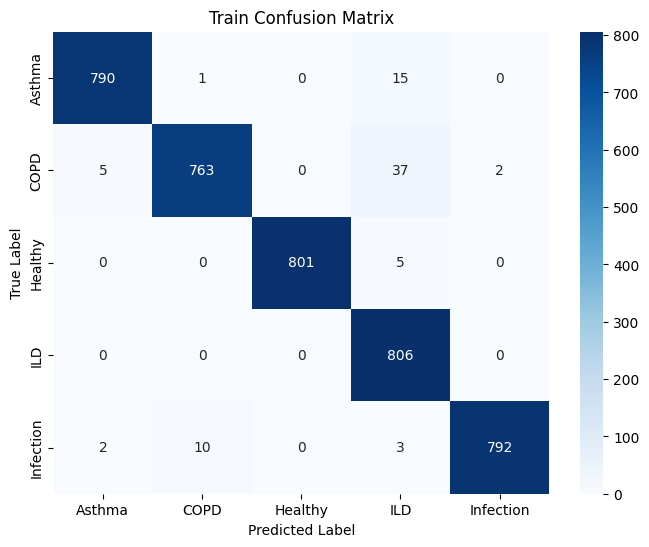

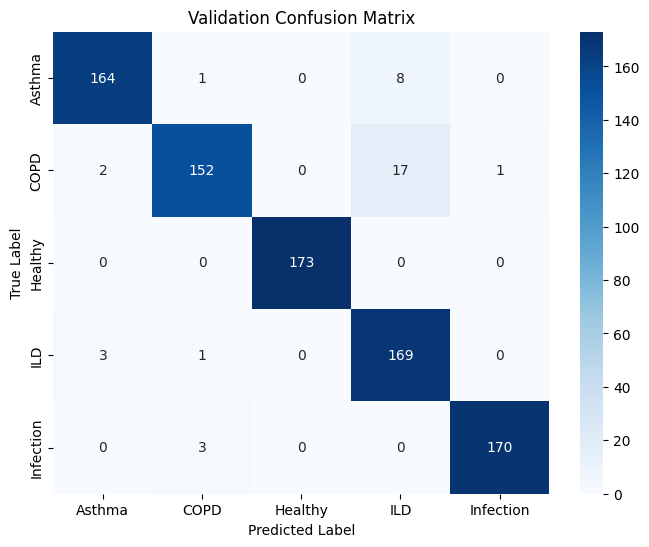

In [15]:
def plot_confusion_matrix(labels, preds, classes, title="Confusion Matrix"):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title(title)
    plt.show()



plot_confusion_matrix(train_labels, train_preds, train_ds.le.classes_, title="Train Confusion Matrix")



plot_confusion_matrix(val_labels, val_preds, val_ds.le.classes_, title="Validation Confusion Matrix")

Predict:   0%|          | 0/126 [00:00<?, ?it/s]

Predict:   0%|          | 0/27 [00:00<?, ?it/s]

Predict:   0%|          | 0/27 [00:00<?, ?it/s]

=== Train Metrics ===
               precision    recall  f1-score      support
Asthma         0.994969  0.981390  0.988132   806.000000
COPD           0.979248  0.935564  0.956907   807.000000
Healthy        1.000000  0.990074  0.995012   806.000000
ILD            0.917526  0.993797  0.954139   806.000000
Infection      0.996226  0.981413  0.988764   807.000000
accuracy       0.976438  0.976438  0.976438     0.976438
macro avg      0.977594  0.976447  0.976591  4032.000000
weighted avg   0.977599  0.976438  0.976589  4032.000000

=== Validation Metrics ===
               precision    recall  f1-score     support
Asthma         0.970414  0.947977  0.959064  173.000000
COPD           0.968153  0.883721  0.924012  172.000000
Healthy        1.000000  1.000000  1.000000  173.000000
ILD            0.871134  0.976879  0.920981  173.000000
Infection      0.994152  0.982659  0.988372  173.000000
accuracy       0.958333  0.958333  0.958333    0.958333
macro avg      0.960771  0.958247  0.958486

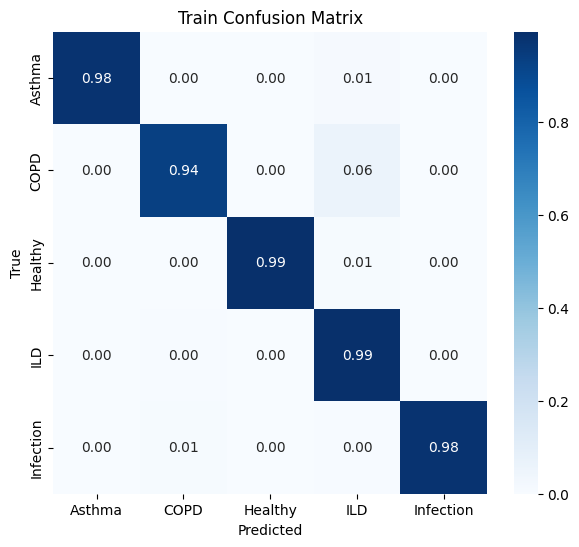

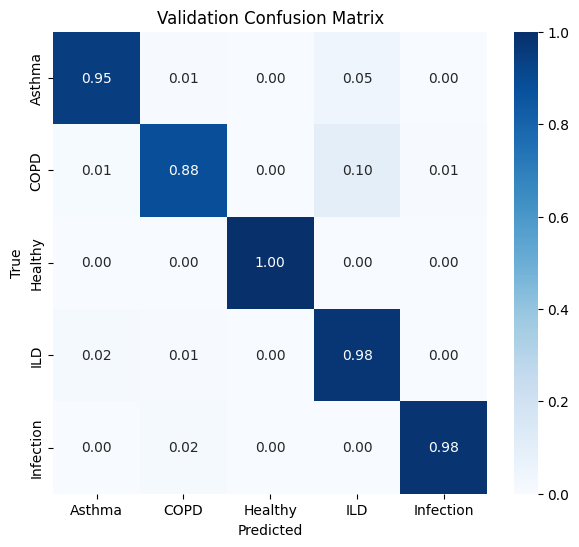

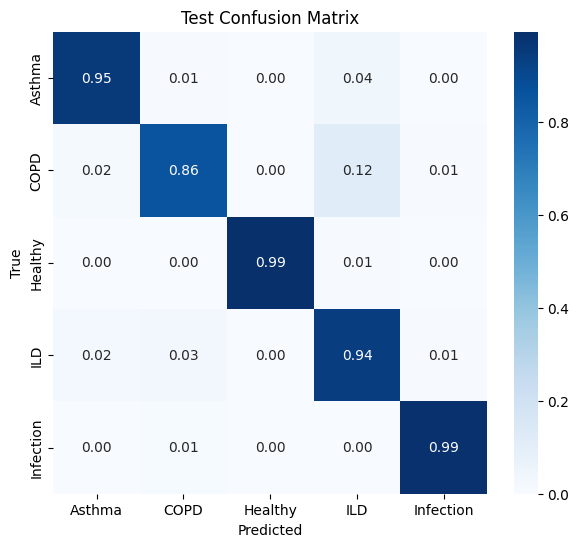

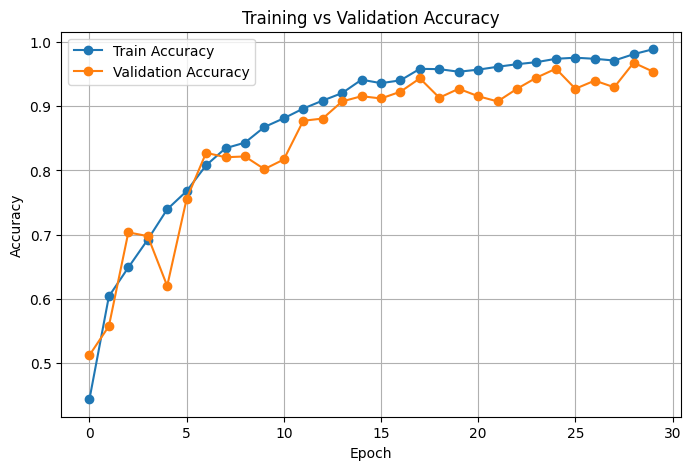

Test Accuracy: 0.9479


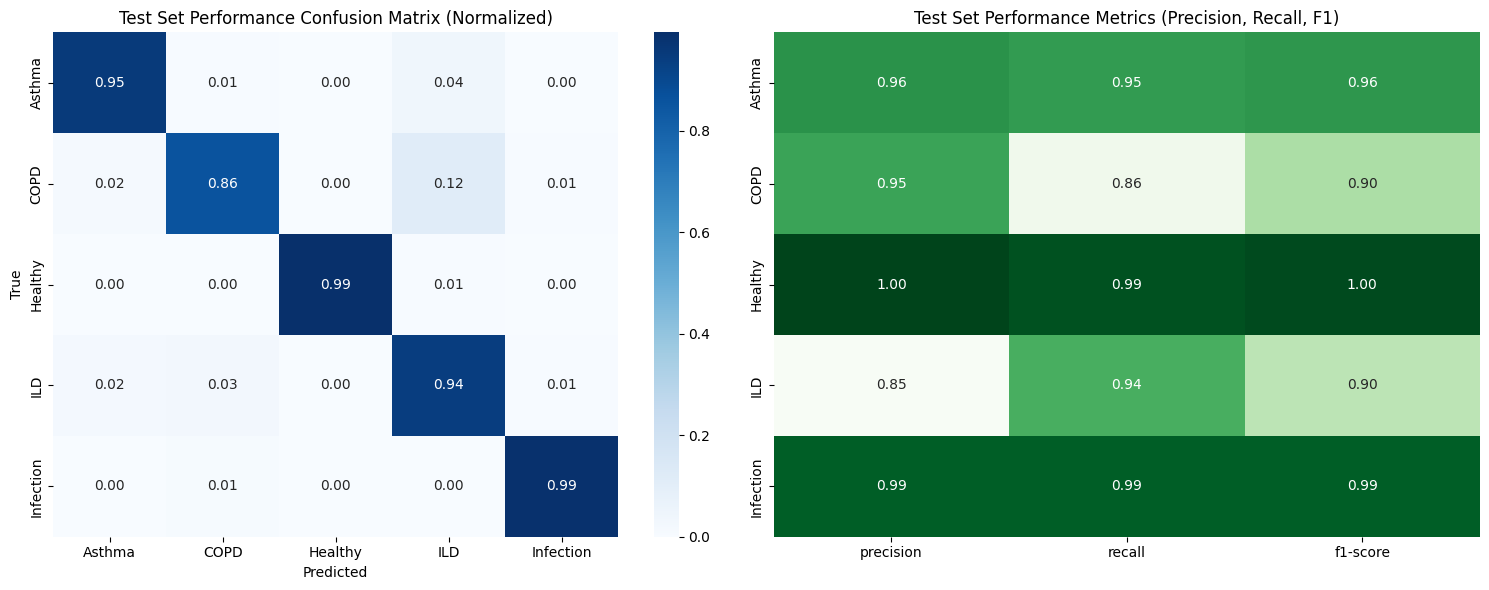

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix


def get_predictions(model, dataloader, device):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predict", leave=False):
            spec, meta, labels = batch["spec"].to(device), batch["meta"].to(device), batch["label"].to(device)
            out = model(spec, meta)
            preds = out.argmax(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

def plot_conf_matrix(labels, preds, classes, title="Confusion Matrix"):
    cm = confusion_matrix(labels, preds)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(7,6))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

def plot_train_val_metrics(train_accs, val_accs):
    plt.figure(figsize=(8,5))
    plt.plot(train_accs, label="Train Accuracy", marker='o')
    plt.plot(val_accs, label="Validation Accuracy", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

classes = train_ds.le.classes_


train_labels, train_preds = get_predictions(model, train_loader, device)
val_labels, val_preds = get_predictions(model, val_loader, device)
test_labels, test_preds = get_predictions(model, test_loader, device)


train_report = classification_report(train_labels, train_preds, target_names=classes, output_dict=True)
val_report = classification_report(val_labels, val_preds, target_names=classes, output_dict=True)
test_report = classification_report(test_labels, test_preds, target_names=classes, output_dict=True)

train_df_metrics = pd.DataFrame(train_report).transpose()
val_df_metrics = pd.DataFrame(val_report).transpose()
test_df_metrics = pd.DataFrame(test_report).transpose()

print("=== Train Metrics ===\n", train_df_metrics)
print("\n=== Validation Metrics ===\n", val_df_metrics)
print("\n=== Test Metrics ===\n", test_df_metrics)


plot_conf_matrix(train_labels, train_preds, classes, title="Train Confusion Matrix")
plot_conf_matrix(val_labels, val_preds, classes, title="Validation Confusion Matrix")
plot_conf_matrix(test_labels, test_preds, classes, title="Test Confusion Matrix")


train_accs = [
    0.4442, 0.6042, 0.6491, 0.6925, 0.7396,
    0.7679, 0.8080, 0.8346, 0.8433, 0.8676,
    0.8812, 0.8963, 0.9087, 0.9204, 0.9412,
    0.9358, 0.9402, 0.9581, 0.9576, 0.9536,
    0.9568, 0.9613, 0.9653, 0.9685, 0.9737,
    0.9754, 0.9737, 0.9710, 0.9809, 0.9886
]

val_accs = [
    0.5127, 0.5579, 0.7037, 0.6979, 0.6204,
    0.7558, 0.8275, 0.8206, 0.8218, 0.8021,
    0.8171, 0.8773, 0.8808, 0.9074, 0.9155,
    0.9120, 0.9225, 0.9433, 0.9132, 0.9271,
    0.9155, 0.9074, 0.9271, 0.9444, 0.9583,
    0.9271, 0.9398, 0.9294, 0.9676, 0.9537
]


plot_train_val_metrics(train_accs, val_accs)


print(f"Test Accuracy: {test_report['accuracy']:.4f}")

def plot_summary(labels, preds, classes, title="Performance Summary"):
    cm = confusion_matrix(labels, preds)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=classes, yticklabels=classes, ax=ax[0])
    ax[0].set_title(f"{title} Confusion Matrix (Normalized)")
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("True")
    
    report = classification_report(labels, preds, target_names=classes, output_dict=True)
    report_df = pd.DataFrame(report).transpose().iloc[:-3,:3] 
    sns.heatmap(report_df, annot=True, fmt=".2f", cmap="Greens", cbar=False, ax=ax[1])
    ax[1].set_title(f"{title} Metrics (Precision, Recall, F1)")
    
    plt.tight_layout()
    plt.show()


plot_summary(test_labels, test_preds, classes, title="Test Set Performance")


In [17]:
classes = train_ds.le.classes_   
classes

array(['Asthma', 'COPD', 'Healthy', 'ILD', 'Infection'], dtype=object)

In [ ]:
import torch
import numpy as np
import librosa


def load_mfcc(mfcc_path):
    mfcc = np.load(mfcc_path)   
    
    mfcc = (mfcc - mfcc.min()) / (mfcc.max() - mfcc.min())
    
    mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32)  
    mfcc_tensor = mfcc_tensor.unsqueeze(0)  
    return mfcc_tensor

def preprocess_metadata(age, gender, bmi):
    
    gender_val = 1 if gender.lower() == "Male" else 0
    meta_tensor = torch.tensor([age, gender_val, bmi], dtype=torch.float32).unsqueeze(0)
    return meta_tensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("/kaggle/working/best_model.pth", map_location=device))  
model.eval().to(device)


def predict(mfcc_path, age, gender, bmi, model, classes):
    spec = load_mfcc(mfcc_path).to(device)
    meta = preprocess_metadata(age, gender, bmi).to(device)
    
    with torch.no_grad():
        output = model(spec, meta)
        probs = torch.softmax(output, dim=1).cpu().numpy().flatten()
        pred_idx = np.argmax(probs)
    
    return classes[pred_idx], probs


classes = train_ds.le.classes_   

mfcc_path = "/kaggle/input/data-aug-20-secs/augmented_data/55/EXTD/55_07_PBL_aug571.npy" 
age, gender, bmi = 10, "Male", 2.3

pred_class, probs = predict(mfcc_path, age, gender, bmi, model, classes)

print(f"Predicted Diagnosis: {pred_class}")
for cls, p in zip(classes, probs):
    print(f"{cls}: {p:.10f}")


Predicted Diagnosis: Infection
Asthma: 0.0000000000
COPD: 0.0000005530
Healthy: 0.0000000000
ILD: 0.0000000000
Infection: 0.9999994040
